In [241]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import seaborn as sns       
from scipy import stats

import warnings

warnings.filterwarnings('ignore')
%matplotlib inline  
# 为了在jupyter notebook里作图，需要用到这个命令

## Load train data and test data
#### 並先刪除不必要的欄位

In [242]:
train = pd.read_csv("train.csv")
#train.drop("ID", axis = 1, inplace = True)
print (train.shape)
# 取出train data的y值
y_train=train['class']
print ("y_train:",y_train.shape)
train.drop(["ID","class"], axis = 1, inplace = True)
x_train=train
print ("x_train:",x_train.shape)


(7160, 184)
y_train: (7160,)
x_train: (7160, 182)


In [243]:
x_test = pd.read_csv("test.csv")
x_test_id=x_test["id"]
x_test.drop(["id"], axis = 1, inplace = True)
print ("x_test:",x_test.shape)
print (train.info())

x_test: (1791, 182)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7160 entries, 0 to 7159
Columns: 182 entries, appearedTimeOfDay to cooc_151
dtypes: bool(168), float64(6), int64(3), object(5)
memory usage: 1.9+ MB
None


## 將train data和test data combine起來，後續一起做資料處理
#### 如果分開做的話，做one-hot-encoding時可能會有feature數量不一致的問題

In [244]:
data=pd.concat([x_train,x_test],axis=0,ignore_index = False)
print (data.shape)
#紀錄train data的筆數,後續EDA完成後要再依此筆數拆分train data和test data
x_train_qty=x_train.shape[0]

(8951, 182)


## 判斷fetures是屬於categorical or numerical

In [245]:
# Differentiate numerical features (minus the target) and categorical features
categorical_features = data.select_dtypes(include=['object']).columns
print(categorical_features)
numerical_features = data.select_dtypes(exclude = ["object"]).columns
print(numerical_features)
print("Categorical features : " + str(len(categorical_features)))
print("Numerical features : " + str(len(numerical_features)))

Index(['appearedTimeOfDay', 'city', 'continent', 'weather', 'weatherIcon'], dtype='object')
Index(['appearedHour', 'appearedMinute', 'terrainType', 'closeToWater',
       'temperature', 'windSpeed', 'pressure', 'population_density', 'urban',
       'suburban',
       ...
       'cooc_142', 'cooc_143', 'cooc_144', 'cooc_145', 'cooc_146', 'cooc_147',
       'cooc_148', 'cooc_149', 'cooc_150', 'cooc_151'],
      dtype='object', length=177)
Categorical features : 5
Numerical features : 177


## 檢查Features datatype

In [246]:
print(data.dtypes.unique())
print(len(data.select_dtypes(include=['O']).columns))
print(data.select_dtypes(include=['O']).columns)

[dtype('O') dtype('int64') dtype('bool') dtype('float64')]
5
Index(['appearedTimeOfDay', 'city', 'continent', 'weather', 'weatherIcon'], dtype='object')


In [247]:
data.head()

,appearedTimeOfDay,appearedHour,appearedMinute,terrainType,closeToWater,city,continent,weather,temperature,windSpeed,...,cooc_142,cooc_143,cooc_144,cooc_145,cooc_146,cooc_147,cooc_148,cooc_149,cooc_150,cooc_151
0,evening,19,10,13,False,Bangkok,Asia,Clear,27.8,9.00,...,False,False,False,False,False,False,False,False,False,False
1,night,5,19,13,True,New_York,America,Clear,26.1,8.70,...,False,False,False,False,False,False,False,False,False,False
2,evening,19,46,0,True,New_York,America,Clear,24.7,16.82,...,False,False,False,False,False,False,False,False,False,False
3,morning,11,10,0,True,Hobart,Australia,Clear,12.7,13.25,...,False,False,False,False,False,False,False,False,False,False
4,evening,18,32,13,True,Los_Angeles,America,PartlyCloudy,19.1,5.78,...,False,False,False,False,False,False,False,False,False,False


In [248]:
data.describe()

,appearedHour,appearedMinute,terrainType,temperature,windSpeed,pressure,population_density,gymDistanceKm,pokestopDistanceKm
count,8951.000000,8951.000000,8951.000000,8951.000000,8951.000000,8951.000000,8951.000000,8951.000000,8951.000000
mean,10.654452,30.643168,9.720590,23.281008,7.510169,1014.904328,1541.905140,2.987937,0.562947
std,7.152858,17.439499,4.941831,6.054764,4.617323,5.828866,2230.860698,46.908371,7.479374
min,0.000000,0.000000,0.000000,4.800000,0.000000,996.330000,0.000000,0.004516,0.000319
25%,4.000000,16.000000,7.000000,18.500000,3.920000,1010.695000,69.585650,0.178437,0.050817
50%,10.000000,32.000000,13.000000,23.800000,6.630000,1015.290000,635.549800,0.314365,0.132209
75%,17.000000,46.000000,13.000000,27.500000,10.010000,1019.290000,1955.863600,0.577406,0.310317
max,23.000000,59.000000,16.000000,41.200000,56.130000,1034.170000,10000.000000,3859.424664,455.313099


## 處理時間欄位

In [249]:
data['appearedtime'] = data['appearedHour']+(data['appearedMinute']/60)
#maxtime=data['appearedtime'].max()
maxtime=24
data['appearedtime'].head()

0    19.166667
1     5.316667
2    19.766667
3    11.166667
4    18.533333
Name: appearedtime, dtype: float64

In [250]:
data['appearedtime_sin'] = np.sin(2 * np.pi * data['appearedtime']/maxtime)
data['appearedtime_cos'] = np.cos(2 * np.pi * data['appearedtime']/maxtime)

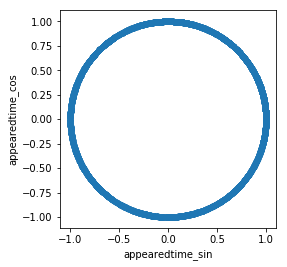

In [251]:
ax = data.plot.scatter('appearedtime_sin', 'appearedtime_cos').set_aspect('equal')

## 刪除不需要的features

In [252]:
# city已經可以區分地區,所以不需要continent
data = data.drop(['continent'], axis=1)
#與weather類似，所以移除weatherIcon
data = data.drop(['weatherIcon'], axis=1)
#data = data.drop(['weather'], axis=1)
data = data.drop(['appearedHour', 'appearedMinute','appearedtime'], axis=1)
# 時間欄位與appearedTimeOfDay效果相似,保留appearedTimeOfDay
#data = data.drop(['appearedTimeOfDay'], axis=1)
data = data.drop(['appearedtime_sin', 'appearedtime_cos'], axis=1)


## 顯示數值欄位基本資訊

In [253]:
data.describe()

,terrainType,temperature,windSpeed,pressure,population_density,gymDistanceKm,pokestopDistanceKm
count,8951.000000,8951.000000,8951.000000,8951.000000,8951.000000,8951.000000,8951.000000
mean,9.720590,23.281008,7.510169,1014.904328,1541.905140,2.987937,0.562947
std,4.941831,6.054764,4.617323,5.828866,2230.860698,46.908371,7.479374
min,0.000000,4.800000,0.000000,996.330000,0.000000,0.004516,0.000319
25%,7.000000,18.500000,3.920000,1010.695000,69.585650,0.178437,0.050817
50%,13.000000,23.800000,6.630000,1015.290000,635.549800,0.314365,0.132209
75%,13.000000,27.500000,10.010000,1019.290000,1955.863600,0.577406,0.310317
max,16.000000,41.200000,56.130000,1034.170000,10000.000000,3859.424664,455.313099


## 判斷是否有missing data

In [254]:
# Missing data in train
data_na = data.isnull().sum()
data_na = data_na[data_na>0]
data_na.sort_values(ascending=False)

Series([], dtype: int64)

## 查看min為0的筆數是否異常

In [255]:
print (data.loc[(data['population_density']==0),'population_density'].count())
data.loc[(data['population_density']==0),'population_density'].count()/data.shape[0]

1652


0.18456038431460173

## 將數值為不應該為0的值改用平均值

In [256]:
# 使用該city的population_density平均值取代0值
for i in data['city'].unique():
    mean=data[data['city']==i].loc[:,'population_density'].mean()
    data.loc[(data['city']==i) & (data['population_density']==0),'population_density']=mean

In [257]:
data.head()

,appearedTimeOfDay,terrainType,closeToWater,city,weather,temperature,windSpeed,pressure,population_density,urban,...,cooc_142,cooc_143,cooc_144,cooc_145,cooc_146,cooc_147,cooc_148,cooc_149,cooc_150,cooc_151
0,evening,13,False,Bangkok,Clear,27.8,9.00,1008.96,6019.04440,True,...,False,False,False,False,False,False,False,False,False,False
1,night,13,True,New_York,Clear,26.1,8.70,1018.96,1172.14576,False,...,False,False,False,False,False,False,False,False,False,False
2,evening,0,True,New_York,Clear,24.7,16.82,1023.22,1172.14576,False,...,False,False,False,False,False,False,False,False,False,False
3,morning,0,True,Hobart,Clear,12.7,13.25,1014.19,128.89505,False,...,False,False,False,False,False,False,False,False,False,False
4,evening,13,True,Los_Angeles,PartlyCloudy,19.1,5.78,1011.36,4188.39100,True,...,False,False,False,False,False,False,False,False,False,False


In [258]:
data.describe()

,terrainType,temperature,windSpeed,pressure,population_density,gymDistanceKm,pokestopDistanceKm
count,8951.000000,8951.000000,8951.000000,8951.000000,8951.000000,8951.000000,8951.000000
mean,9.720590,23.281008,7.510169,1014.904328,1786.441753,2.987937,0.562947
std,4.941831,6.054764,4.617323,5.828866,2143.401196,46.908371,7.479374
min,0.000000,4.800000,0.000000,996.330000,0.000000,0.004516,0.000319
25%,7.000000,18.500000,3.920000,1010.695000,458.582340,0.178437,0.050817
50%,13.000000,23.800000,6.630000,1015.290000,1135.319600,0.314365,0.132209
75%,13.000000,27.500000,10.010000,1019.290000,2261.157000,0.577406,0.310317
max,16.000000,41.200000,56.130000,1034.170000,10000.000000,3859.424664,455.313099


## 將以數值做分類型態的feature的資料型態轉換成字串，避免訓練時被當作數值處理
#### 例terrainType是以0,1,2..來表示不同種類的地形，但並非數值，所以要做轉換

In [259]:
#data.terrainType = data.terrainType.astype( str )
features_to_str=["terrainType"]
data[features_to_str]=data[features_to_str].astype(str)
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8951 entries, 0 to 1790
Columns: 178 entries, appearedTimeOfDay to cooc_151
dtypes: bool(168), float64(6), object(4)
memory usage: 2.2+ MB


## 對數值欄位做 normalization

In [260]:
from sklearn import preprocessing
# 前面已經取過一次numerical_features,但因為中間features有增減，所以再取一次
numerical_features = data.select_dtypes(exclude = ["object"]).columns
data[numerical_features] = preprocessing.scale(data[numerical_features])
print (data.head())

  appearedTimeOfDay terrainType  closeToWater         city       weather  \
0           evening          13     -0.901079      Bangkok         Clear   
1             night          13      1.109781     New_York         Clear   
2           evening           0      1.109781     New_York         Clear   
3           morning           0      1.109781       Hobart         Clear   
4           evening          13      1.109781  Los_Angeles  PartlyCloudy   

   temperature  windSpeed  pressure  population_density     urban    ...     \
0     0.746395   0.322679 -1.019866            1.974824  1.133395    ...      
1     0.465609   0.257703  0.695830           -0.286615 -0.882305    ...      
2     0.234373   2.016396  1.426716           -0.286615 -0.882305    ...      
3    -1.747648   1.243178 -0.122557           -0.773369 -0.882305    ...      
4    -0.690571  -0.374733 -0.608099            1.120688  1.133395    ...      

   cooc_142  cooc_143  cooc_144  cooc_145  cooc_146  cooc_147  cooc_

## 對類別型featyres做one-hot-encoding
#### 某一類別型feature有三個值，則會被轉換成三個features

In [261]:
data=pd.get_dummies(data)
data.shape

(8951, 292)

In [262]:
feture_qty=data.shape[1]
print (feture_qty)

292


## 將整理後的資料再拆成train data和test data

In [263]:
x_train=data[:x_train_qty]
x_test=data[x_train_qty:]
print (x_train.shape)
print (x_test.shape)

(7160, 292)
(1791, 292)


## 對train data y 做 one-hot-encoding

In [264]:
# one hot encoding

y_one_hot = np.zeros((len(y_train), 6))  
y_one_hot[np.arange(len(y_train)), y_train] = 1

print (y_one_hot.shape)


(7160, 6)


## 用 keras 建 model

In [265]:
#import tensorflow as tf
#from tensorflow.keras.layers import Dense
#from tensorflow.keras.layers import Dropout
import keras
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout, Activation


#使用dropout無太大變化
#使用2個隱藏層沒太大變化
#model = tf.keras.Sequential()
model = keras.Sequential()
model.add(Dropout(0.4, input_shape=(feture_qty,)))
model.add(Dense(200,activation='relu'))
#model.add(Dense(128, activation='relu', input_shape=(feture_qty,)))
model.add(Dropout(0.4))
model.add(Dense(100, activation='relu'))
model.add(Dropout(0.4))
#model.add(Dense(50, activation='relu')) #多這一層沒幫助
#model.add(Dropout(0.3))
model.add(Dense(6, activation='softmax')) 

print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dropout_13 (Dropout)         (None, 292)               0         
_________________________________________________________________
dense_13 (Dense)             (None, 200)               58600     
_________________________________________________________________
dropout_14 (Dropout)         (None, 200)               0         
_________________________________________________________________
dense_14 (Dense)             (None, 100)               20100     
_________________________________________________________________
dropout_15 (Dropout)         (None, 100)               0         
_________________________________________________________________
dense_15 (Dense)             (None, 6)                 606       
Total params: 79,306
Trainable params: 79,306
Non-trainable params: 0
_________________________________________________________________
None


In [266]:
opt=keras.optimizers.Adam()
#opt=keras.optimizers.SGD() #相同條件下，SGD valid accuracy 0.54562，相較Adam 0.60987差很多
model.compile(loss='categorical_crossentropy',
              optimizer=opt,Adam差
              metrics=['accuracy'])

In [267]:
from keras.callbacks import ModelCheckpoint,EarlyStopping
from keras.models import load_model

## 設定訓練結果存放路徑

In [268]:
import os
model_path = os.path.join(os.getcwd(), 'saved_models')
model_name = 'keras_adam_trained_model.h5'
if not os.path.isdir(model_path):
    os.makedirs(model_path)
model_path_name = os.path.join(model_path, model_name)

## 模型訓練參數設定

In [269]:
# model fit parameter
batch_size = 128 #原本32放大有幫助
epochs = 250 #batch_size調大,epochs也要調大
lr = 0.001 #原本0.01調小有幫助
train_ratio = 0.85 # 調整稍有變化

# check point parameter
cp_monitor='val_acc'

# early stop parameter
es_monitor='val_acc'
es_patience=50


## 取最佳訓練結果-使用ModelCheckpoint方式

In [270]:
checkpoint = ModelCheckpoint(model_path_name, monitor=cp_monitor, 
                             verbose=2, save_best_only=True, save_weights_only=False)

## Early Stop

In [271]:
earlystop = EarlyStopping(monitor=es_monitor, patience=es_patience, verbose=1)

In [272]:
#此case加上"shuffle=False"效果比較好一點?
model_history = model.fit(x=x_train, y=y_one_hot,
                          batch_size=batch_size,
                          epochs=epochs,
                          shuffle=False,
                          validation_split=1 - train_ratio, callbacks=[checkpoint,earlystop])


Train on 6086 samples, validate on 1074 samples
Epoch 1/250
6086/6086 [==============================] - 1s 114us/step - loss: 1.8831 - acc: 0.2547 - val_loss: 1.5765 - val_acc: 0.4311

Epoch 00001: val_acc improved from -inf to 0.43110, saving model to /home/jovyan/mypython/Kaggle/AIA Pokemon/saved_models/keras_adam_trained_model.h5
Epoch 2/250
6086/6086 [==============================] - 0s 21us/step - loss: 1.6347 - acc: 0.3592 - val_loss: 1.4539 - val_acc: 0.4730

Epoch 00002: val_acc improved from 0.43110 to 0.47300, saving model to /home/jovyan/mypython/Kaggle/AIA Pokemon/saved_models/keras_adam_trained_model.h5
Epoch 3/250
6086/6086 [==============================] - 0s 21us/step - loss: 1.5527 - acc: 0.3865 - val_loss: 1.3740 - val_acc: 0.4907

Epoch 00003: val_acc improved from 0.47300 to 0.49069, saving model to /home/jovyan/mypython/Kaggle/AIA Pokemon/saved_models/keras_adam_trained_model.h5
Epoch 4/250
6086/6086 [==============================] - 0s 22us/step - loss: 1.4938

In [273]:
train_loss = model_history.history['loss']
train_acc = model_history.history['acc']
valid_loss = model_history.history['val_loss']
valid_acc = model_history.history['val_acc']

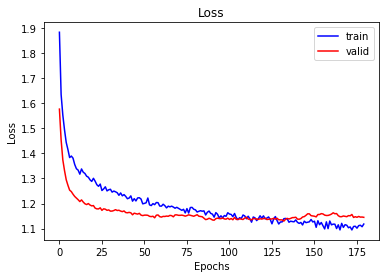

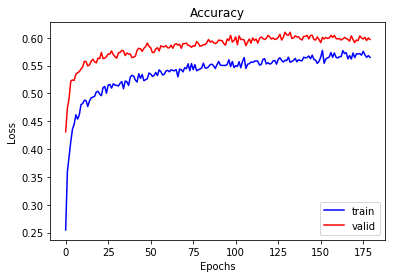

In [274]:
plt.plot(train_loss, 'b', label='train')
plt.plot(valid_loss, 'r', label='valid')
plt.legend()
plt.title("Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(loc='best')
plt.show()

plt.plot(train_acc, 'b', label='train')
plt.plot(valid_acc, 'r', label='valid')
plt.title("Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(loc='best')
plt.show()

In [275]:
# save model，存最後的結果。
# 此case是用checkpoint存最佳的valid accuracy結果，所以將此mark掉
#model.save('my_model.h5')

## 取訓練時最佳的結果來做test預測

In [276]:
# load model
another_model = load_model(model_path_name)

In [277]:
y_test_pred = model.predict_classes(x_test)

In [278]:
## 將預測結果與ID做combine
prediction = pd.DataFrame(y_test_pred, columns=['class'])
result = pd.concat([x_test_id, prediction], axis=1)
result.head()

,id,class
0,MTA5MTEwOTYxMzM0NzA2NDEzNzM=,2
1,MTY0OTUyMTM2MDExMjg3MjczMjU=,1
2,MTQ0ODU1OTEzOTU1NTAyNzI4NjE=,4
3,MTY1ODg1MzEwNzYzNDUzMDUwNTM=,3
4,MTY0NTg2OTA5MTkzOTE2MTc1MTc=,5


In [279]:
#儲存結果
result.to_csv('submission_dl.csv', index=False)